# Project 2
#### Problem Statement

> An analysis of paleo-present climate data
>
> * Analyse CO2 vs Temperature Anomaly from 800kyrs – present.
> * Examine one other (paleo/modern) features (e.g. CH4 or polar ice-coverage)
> * Examine Irish context:
>   * Climate change signals: (see Maynooth study: The emergence of a climate change signal in long-term Irish meteorological observations - ScienceDirect)
> * Fuse and analyse data from various data sources and format fused data set as a pandas dataframe and export to csv and json formats
> * For all of the above variables, analyse the data, the trends and the relationships between them (temporal leads/lags/frequency      analysis).
> * Predict global temperature anomaly over next few decades (synthesise data) and compare to published climate models if atmospheric CO2 trends continue
> * Comment on accelerated warming based on very latest features (e.g. temperature/polar-icecoverage)
>
> Use a Jupyter notebook for your analysis and track your progress using GitHub.
>
> Use an academic referencing style


In [1]:
# Import the following libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

Install xlrd in anaconda to allow pandas to read .xls files\
use the following command: conda install -c anaconda xlrd\
https://anaconda.org/anaconda/xlrd

In [2]:
# Example of how to download xl files and create csv files

# CO2 data from Luthi et al. 2008 Nature Paper
url = 'data/41586_2008_BFnature06949_MOESM31_ESM.xls'

Sheet1 = 'data/csv_files/2008_nature_new_CO2_data.csv'
Sheet2 = 'data/csv_files/2008_nature_Vostok_TD_Dome_C.csv'
Sheet3 = 'data/csv_files/2008_nature_Composite_CO2.csv'
df1=pd.read_excel(url, '1.  new CO2 data')
df2=pd.read_excel(url, '2.  Vostok-TD-Dome C')
df3=pd.read_excel(url, '3.  Composite CO2')

df1.to_csv(Sheet1)
df2.to_csv(Sheet2)
df3.to_csv(Sheet3)

In [3]:
df = pd.DataFrame().assign(nature_year =df3['Composite CO2 record (0-800 kyr BP)'], nature_co2_ppmv = df3['Unnamed: 1'])
df = df.drop(labels=range(0, 6), axis=0)

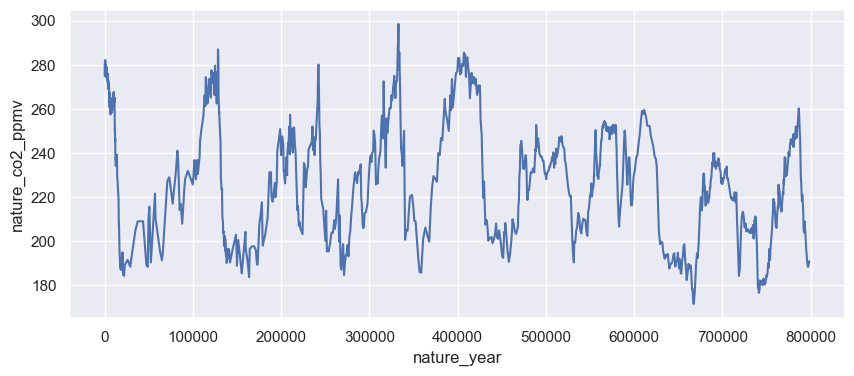

In [4]:
# Replicate plot year vs CO2

plt.style.use('ggplot')
sns.set(rc = {'figure.figsize':(10, 4)})
sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df)
plt.show()

In [5]:
df4=pd.read_csv('data/csv_files/grl52461_composite_data.csv')
df.insert(2, 'IPCC_year', df4['Gasage (yr BP)'])
df.insert(3, 'IPCC_co2_ppmv', df4['CO2 (ppmv)'])

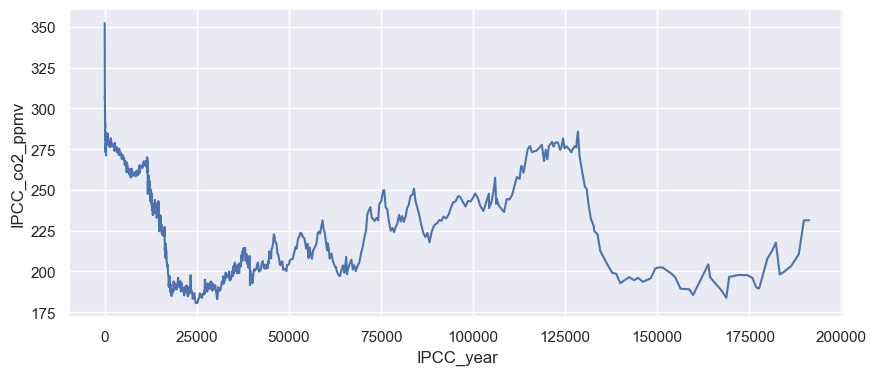

In [6]:
sns.lineplot(x = 'IPCC_year', y = 'IPCC_co2_ppmv', data=df)

plt.show()

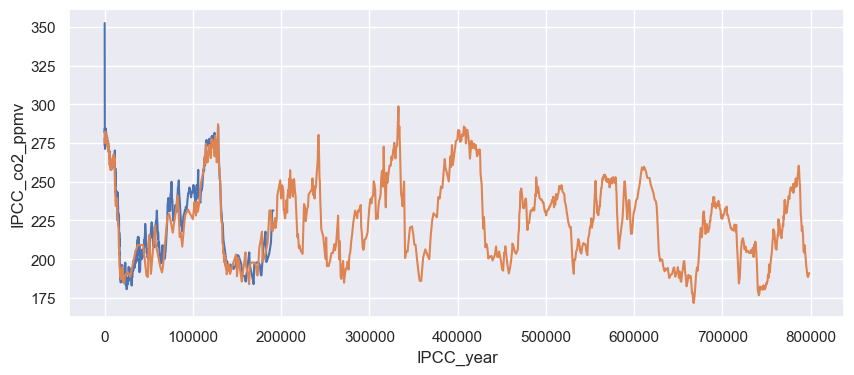

In [7]:
sns.lineplot(x = 'IPCC_year', y = 'IPCC_co2_ppmv', data=df)
sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df)
plt.show()

In [8]:
df.to_csv('data/csv_files/co2_data.csv')

In [9]:
df5=pd.read_csv('data/csv_files/edc3deuttemp_2007.csv')
df6=pd.read_csv('data/csv_files/epicaDC_deuttemp_EDC3-AICC.csv', encoding = "ISO-8859-1")

In [10]:
df_temp = pd.DataFrame().assign(edc_age =df5['Age'], edc_temp_anomaly = df5['Temperature'])
df_temp.insert(2, 'epica_age', df6['EDC3béta'])
df_temp.insert(3, 'epica_temp', df6['temp'])

df_temp['edc_temp'] = df_temp['edc_temp_anomaly']
temp_column = df_temp['edc_temp']
def add_offset(x):
    x += 218.3
    return x
new_temp_column = temp_column.apply(add_offset)
df_temp['edc_temp'] = new_temp_column

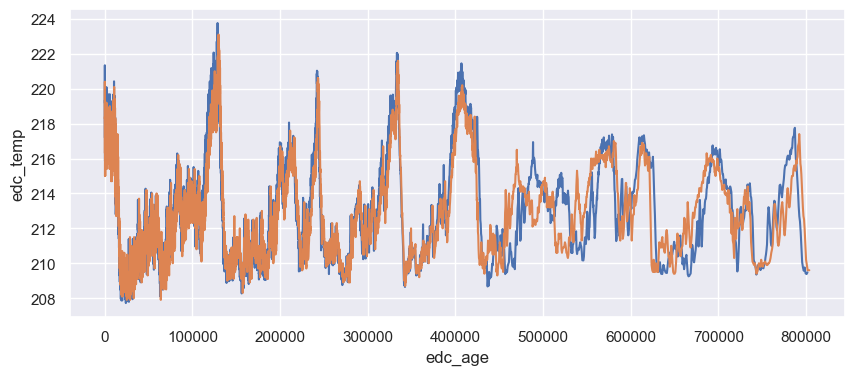

In [11]:
sns.lineplot(x = 'edc_age', y = 'edc_temp', data=df_temp)
sns.lineplot(x = 'epica_age', y = 'epica_temp', data=df_temp)
plt.show()

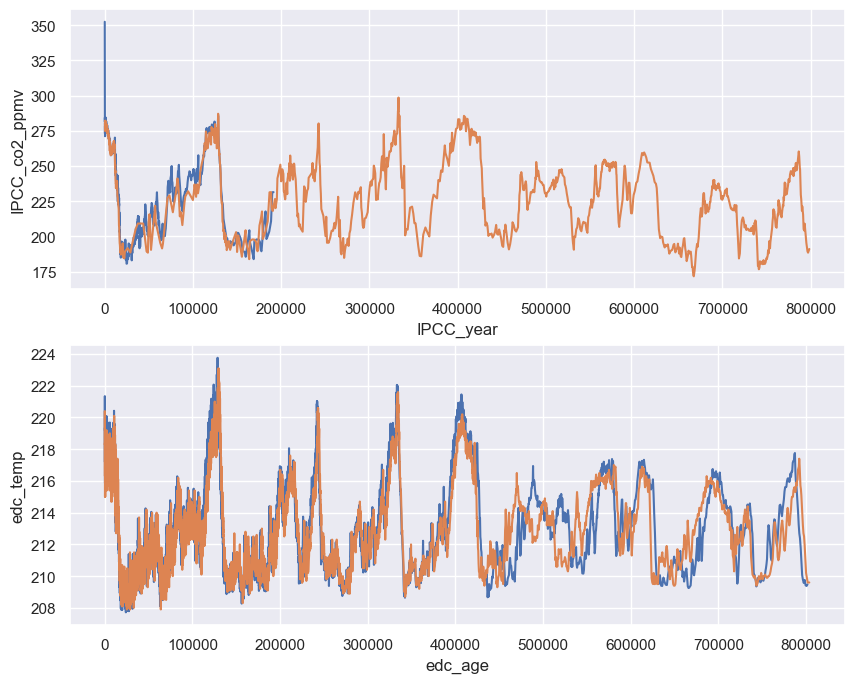

In [12]:
# co2 vs. temp
sns.set(rc = {'figure.figsize':(10, 8)})
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=False)

sns.lineplot(x = 'IPCC_year', y = 'IPCC_co2_ppmv', data=df, ax = ax1)
sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df, ax = ax1)
sns.lineplot(x = 'edc_age', y = 'edc_temp', data=df_temp, ax = ax2)
sns.lineplot(x = 'epica_age', y = 'epica_temp', data=df_temp, ax = ax2)
plt.show()

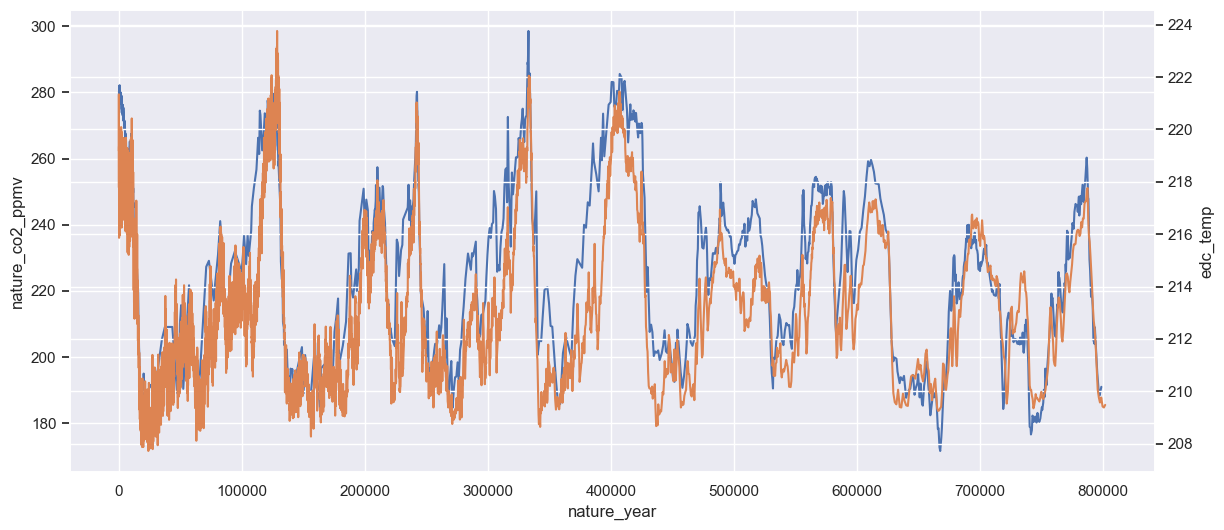

In [13]:
# co2 vs. temp overlay
sns.set(rc = {'figure.figsize':(14, 6)})
fig, (ax) = plt.subplots(nrows=1, sharex=False)


sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df)
ax2 = plt.twinx()
sns.lineplot(x = 'edc_age', y = 'edc_temp', data=df_temp,color='#dd8452')

plt.show()



Even though ice cores show that methane levels have varied significantly over the past millennia, methane concentrations began to rise sharply with the onset of industrialization.

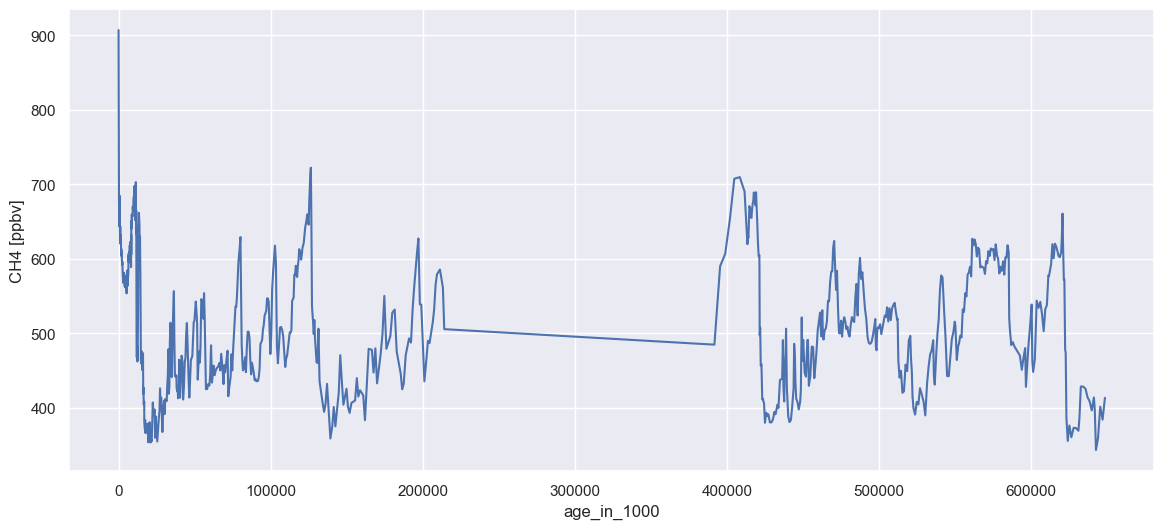

In [14]:
df_ch4_2=pd.read_csv('data/csv_files/EPICA Dome C methane.csv')
df_ch4_2['age_in_1000'] = df_ch4_2['Gas age']
temp_column = df_ch4_2['age_in_1000']
def add_offset(x):
    x *= 1000
    return x
new_temp_column = temp_column.apply(add_offset)
df_ch4_2['age_in_1000'] = new_temp_column
sns.lineplot(x = 'age_in_1000', y = 'CH4 [ppbv]', data=df_ch4_2)
plt.show()

In [15]:
# add a row to make the timelines match
new_row = [820, 400, 798512]
df_ch4_2.loc[len(df_ch4_2)] = new_row

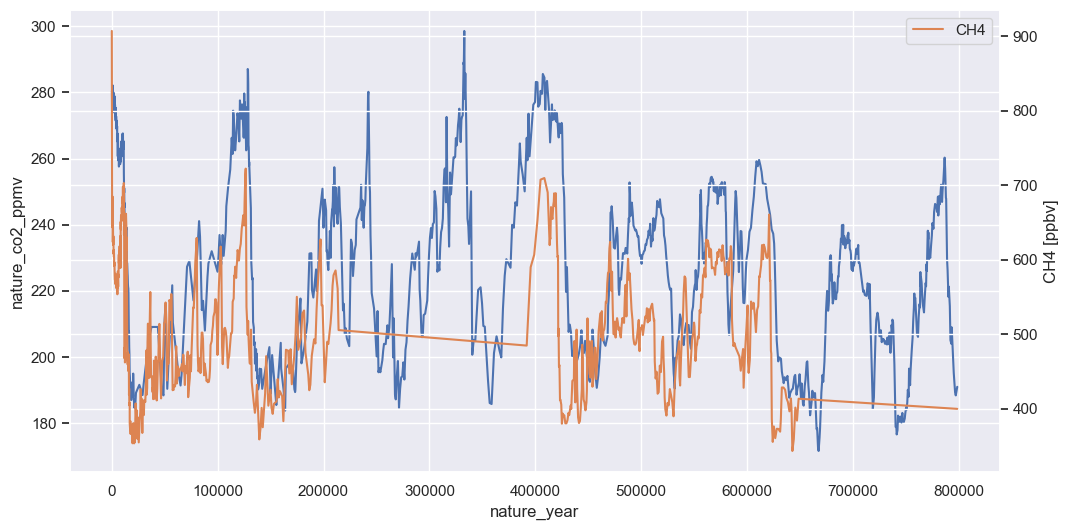

In [16]:
# co2 vs. ch4
sns.set(rc = {'figure.figsize':(12, 6)})
fig, (ax) = plt.subplots(nrows=1, sharex=False)

sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df)
ax2 = plt.twinx()
sns.lineplot(x = 'age_in_1000', y = 'CH4 [ppbv]', data=df_ch4_2, label = 'CH4',color='#dd8452')
plt.show()

#### Irish Data

In [17]:
df_ie_rain=pd.read_csv('data/csv_files/1711_rainfall.csv')

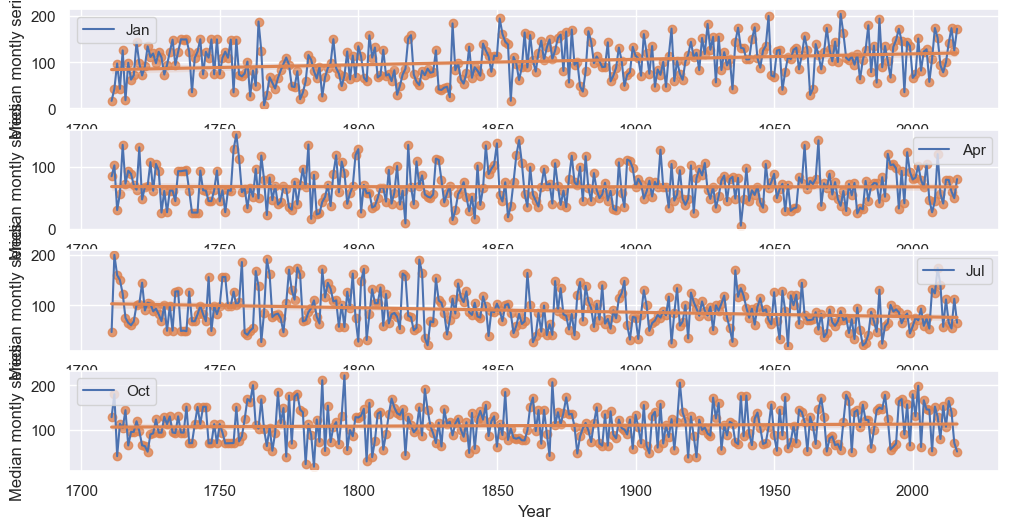

In [18]:
df_jan_rain = df_ie_rain[df_ie_rain['Month'] == 1]
df_apr_rain = df_ie_rain[df_ie_rain['Month'] == 4]
df_jul_rain = df_ie_rain[df_ie_rain['Month'] == 7]
df_oct_rain = df_ie_rain[df_ie_rain['Month'] == 10]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=False)
sns.set(rc = {'figure.figsize':(12, 20)})

sns.lineplot(x = 'Year', y = 'Median montly series', data=df_jan_rain, label = 'Jan', ax = ax1)
sns.regplot(x = 'Year', y = 'Median montly series', data=df_jan_rain, ax = ax1)
sns.lineplot(x = 'Year', y = 'Median montly series', data=df_apr_rain, label = 'Apr', ax = ax2)
sns.regplot(x = 'Year', y = 'Median montly series', data=df_apr_rain, ax = ax2)
sns.lineplot(x = 'Year', y = 'Median montly series', data=df_jul_rain,label = 'Jul', ax = ax3)
sns.regplot(x = 'Year', y = 'Median montly series', data=df_jul_rain, ax = ax3)
sns.lineplot(x = 'Year', y = 'Median montly series', data=df_oct_rain,label = 'Oct', ax = ax4)
sns.regplot(x = 'Year', y = 'Median montly series', data=df_oct_rain, ax = ax4)
plt.show()

#### instrument data
https://gml.noaa.gov/ccgg/trends/gl_data.html

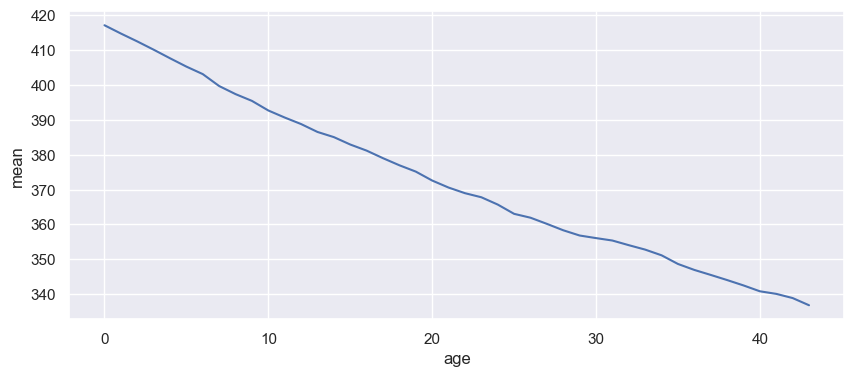

In [19]:
df_air_co2=pd.read_csv('data/csv_files/co2_gl_air_sample.csv')
df_air_co2['age'] = df_air_co2['year']
temp_column = df_air_co2['age']
def cal_age(x):
    x = 2022 - x
    return x
new_temp_column = temp_column.apply(cal_age)
df_air_co2['age'] = new_temp_column

sns.set(rc = {'figure.figsize':(10, 4)})
sns.lineplot(x = 'age', y = 'mean', data=df_air_co2)
plt.show()

#### grafting data

In [20]:
df_graft = df3
df_graft = df_graft.drop(labels=range(0, 6), axis=0)
df_graft = pd.DataFrame().assign(age =df_graft['Composite CO2 record (0-800 kyr BP)'], co2_ppmv = df_graft['Unnamed: 1'])

In [21]:
df_graft_2 = df_air_co2
df_graft_2 = df_graft_2.drop(['year', 'unc'], axis = 1)
df_graft_2 = df_graft_2[['age', 'mean']]
df_graft_2 = pd.DataFrame().assign(age =df_graft_2['age'], co2_ppmv = df_graft_2['mean'])

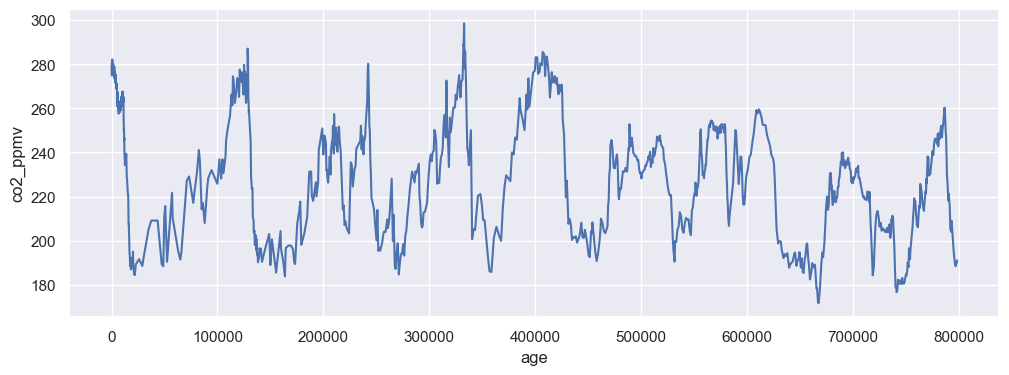

In [22]:
df_graft_co2 = pd.concat([df_graft, df_graft_2])
sns.set(rc = {'figure.figsize':(12, 4)})
sns.lineplot(x = 'age', y = 'co2_ppmv', data=df_graft)
plt.show()

In [23]:
#export as CSV
df_graft_co2.to_csv('data/csv_files/grafted_CO2_data.csv')

In [24]:
# export as json
df_graft_co2.to_json('data/csv_files/grafted_CO2_data.json', orient='records', lines=True)

In [25]:
dftemp=pd.read_csv('data/csv_files/grafted_CO2_data.csv')

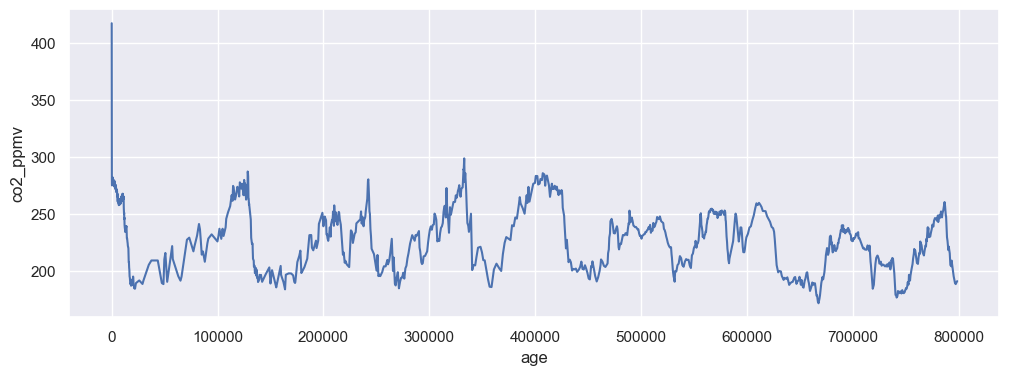

In [26]:
sns.lineplot(x = 'age', y = 'co2_ppmv', data=dftemp)
plt.show()

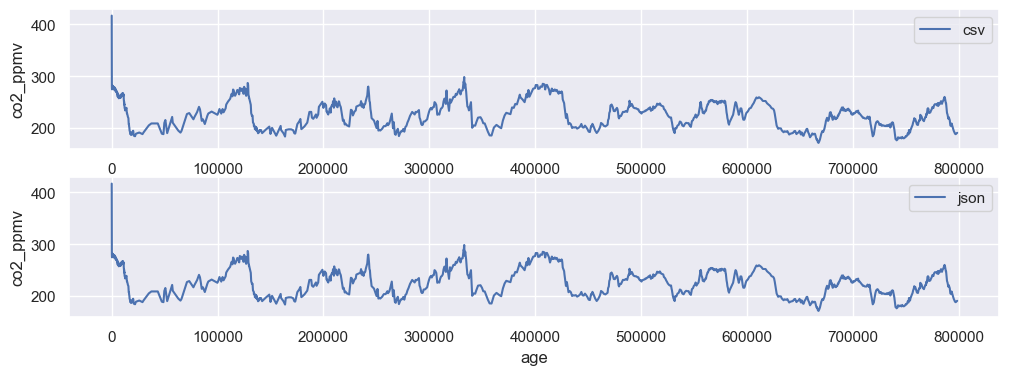

In [27]:
# test files
df_csv=pd.read_csv('data/csv_files/grafted_CO2_data.csv')
df_json=pd.read_json('data/csv_files/grafted_CO2_data.json', lines=True)

fig, (ax1, ax2) = plt.subplots(nrows=2)
sns.lineplot(x = 'age', y = 'co2_ppmv', data=df_csv, label = 'csv', ax = ax1)
sns.lineplot(x = 'age', y = 'co2_ppmv', data=df_json, label = 'json', ax = ax2)
plt.show()